In [1]:
%%capture
!pip install pingouin
!pip install ppscore
!pip install category_encoders

In [6]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.9 MB/s eta 0:00:00


In [7]:
# Data manipulation
#===============================================================================
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

# Data visualization
#===============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Stats
#===============================================================================
import pingouin as pg
import ppscore as pps
import statsmodels.api as sm

# Data preprocessing
#===============================================================================
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Models
#===============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, BaggingClassifier

# Metrics
#===============================================================================
from sklearn.metrics import fbeta_score, confusion_matrix, classification_report


# Counter
#===============================================================================
from collections import Counter

# Optuna
#===============================================================================
import optuna

# warnings
#===============================================================================
import warnings
warnings.filterwarnings('ignore')

In [8]:
data = pd.read_csv("Predict Hair Fall.csv")

data.head()

,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,133992,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,148393,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,155074,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,118261,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,111915,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [9]:
rows, cols = data.shape[0], data.shape[1]

print(f'Rows: {rows}')
print(f'Columns: {cols}')

Rows: 999
Columns: 13


In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Id                         999 non-null    int64 
 1   Genetics                   999 non-null    object
 2   Hormonal Changes           999 non-null    object
 3   Medical Conditions         999 non-null    object
 4   Medications & Treatments   999 non-null    object
 5   Nutritional Deficiencies   999 non-null    object
 6   Stress                     999 non-null    object
 7   Age                        999 non-null    int64 
 8   Poor Hair Care Habits      999 non-null    object
 9   Environmental Factors      999 non-null    object
 10  Smoking                    999 non-null    object
 11  Weight Loss                999 non-null    object
 12  Hair Loss                  999 non-null    int64 
dtypes: int64(3), object(10)
memory usage: 101.6+ KB
None


 **EDA**

In [11]:
print(data.duplicated().sum())

0


In [12]:
data.isnull().sum()

,0
Id,0
Genetics,0
Hormonal Changes,0
Medical Conditions,0
Medications & Treatments,0
Nutritional Deficiencies,0
Stress,0
Age,0
Poor Hair Care Habits,0
Environmental Factors,0


In [13]:
data = data.drop('Id', axis = 1)

data.head()

,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [14]:
data.columns = data.columns.str.strip().str.replace(" ", "_")

data.head()

,Genetics,Hormonal_Changes,Medical_Conditions,Medications_&_Treatments,Nutritional_Deficiencies,Stress,Age,Poor_Hair_Care_Habits,Environmental_Factors,Smoking,Weight_Loss,Hair_Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [15]:
data_eda = data.copy()

data_eda.head()

,Genetics,Hormonal_Changes,Medical_Conditions,Medications_&_Treatments,Nutritional_Deficiencies,Stress,Age,Poor_Hair_Care_Habits,Environmental_Factors,Smoking,Weight_Loss,Hair_Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [16]:
label_hair = {0:'No', 1:'Yes'}

data_eda['Hair_Loss'] = data_eda['Hair_Loss'].map(label_hair)

data_eda.head()

,Genetics,Hormonal_Changes,Medical_Conditions,Medications_&_Treatments,Nutritional_Deficiencies,Stress,Age,Poor_Hair_Care_Habits,Environmental_Factors,Smoking,Weight_Loss,Hair_Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,No
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,No
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,No
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,No
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,Yes


**Univariate Analysis**

In [17]:
numerical_feature = 'Age'

categorical_features = data_eda.select_dtypes(include = ['object', 'category']).columns.to_list()

In [18]:
print(f'Total categorical features: {len(categorical_features)}')

Total categorical features: 11


In [19]:
for i in categorical_features:
    print(f'{i}: {data[i].unique()}\n')

Genetics: ['Yes' 'No']

Hormonal_Changes: ['No' 'Yes']

Medical_Conditions: ['No Data' 'Eczema' 'Dermatosis' 'Ringworm' 'Psoriasis' 'Alopecia Areata '
 'Scalp Infection' 'Seborrheic Dermatitis' 'Dermatitis' 'Thyroid Problems'
 'Androgenetic Alopecia']

Medications_&_Treatments: ['No Data' 'Antibiotics' 'Antifungal Cream' 'Accutane' 'Chemotherapy'
 'Steroids' 'Rogaine' 'Blood Pressure Medication' 'Immunomodulators'
 'Antidepressants ' 'Heart Medication ']

Nutritional_Deficiencies: ['Magnesium deficiency' 'Protein deficiency' 'Biotin Deficiency '
 'Iron deficiency' 'Selenium deficiency' 'Omega-3 fatty acids'
 'Zinc Deficiency' 'Vitamin A Deficiency' 'Vitamin D Deficiency' 'No Data'
 'Vitamin E deficiency']

Stress: ['Moderate' 'High' 'Low']

Poor_Hair_Care_Habits: ['Yes' 'No']

Environmental_Factors: ['Yes' 'No']

Smoking: ['No' 'Yes']

Weight_Loss: ['No' 'Yes']

Hair_Loss: [0 1]



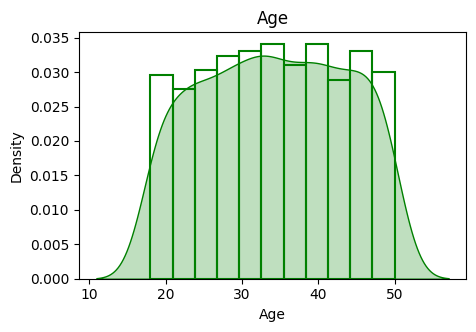

In [20]:
plt.figure(figsize = (5,3.2))
sns.kdeplot(data_eda, x = numerical_feature, fill = True, color = 'green')
sns.histplot(data_eda, x = numerical_feature, stat = 'density', fill = False, color = 'green')
plt.title(f"{numerical_feature}", color = 'black')
plt.show()

<Figure size 300x320 with 0 Axes>

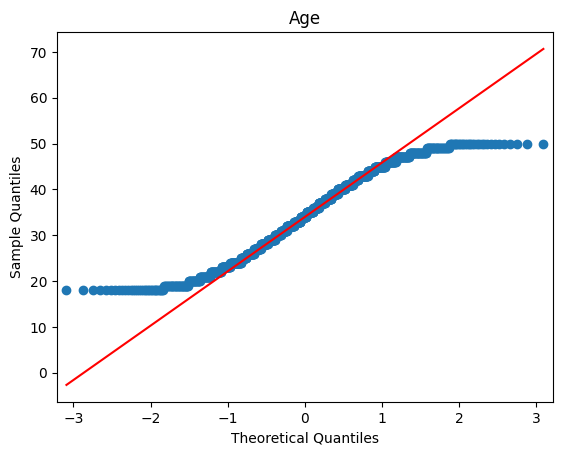

In [21]:
plt.figure(figsize = (3,3.2))
sm.qqplot(data_eda[numerical_feature], line = 'q', lw = 2.1)
plt.title(f'{numerical_feature}', color = 'black')
plt.show()

In [22]:
print(f'Skewness: {data_eda[numerical_feature].skew()}')
print(f'Kurtosis: {data_eda[numerical_feature].kurt()}')

Skewness: -0.034500434760795506
Kurtosis: -1.1456459144705788


In [23]:
pg.normality(data_eda[numerical_feature])

,W,pval,normal
Age,0.957517,1.972355e-16,False


In [24]:
fig = px.pie(data_eda[categorical_features[0]].value_counts().to_frame().reset_index(),
             values= categorical_features[0],
             names = 'index',
             title=f'{categorical_features[0]}')
fig.show()

In [25]:
fig = px.pie(data_eda[categorical_features[1]].value_counts().to_frame().reset_index(),
             values= categorical_features[1],
             names = 'index',
             title=f'{categorical_features[1]}')
fig.show()

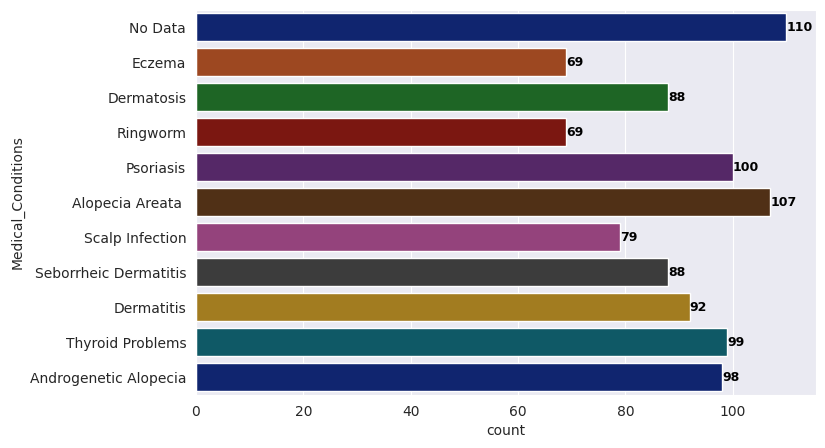

In [26]:
sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data_eda, y = categorical_features[2], palette = 'dark')

for bars in ax.containers:
    ax.bar_label(bars, fontsize = 9, fontweight = 'bold', color = 'black')

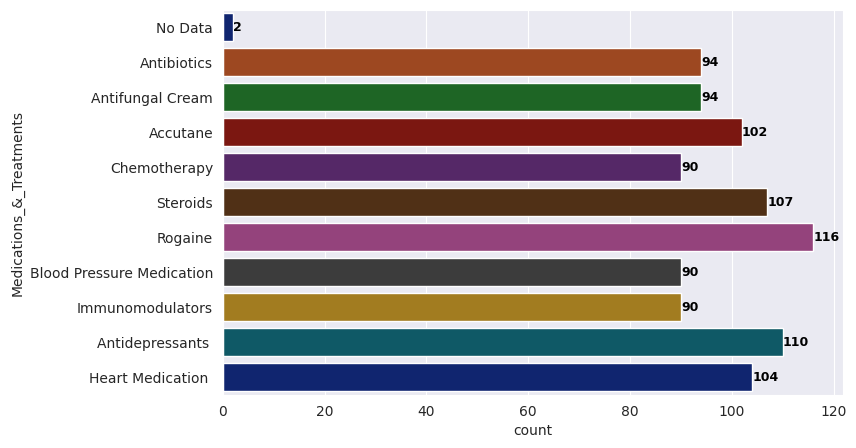

In [27]:
sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data_eda, y = categorical_features[3], palette = 'dark')

for bars in ax.containers:
    ax.bar_label(bars, fontsize = 9, fontweight = 'bold', color = 'black')

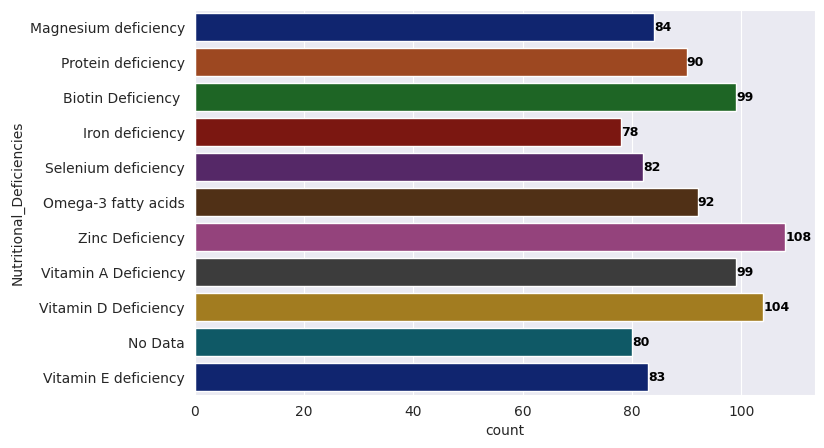

In [28]:
sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data_eda, y = categorical_features[4], palette = 'dark')

for bars in ax.containers:
    ax.bar_label(bars, fontsize = 9, fontweight = 'bold', color = 'black')

In [29]:
fig = px.pie(data_eda[categorical_features[5]].value_counts().to_frame().reset_index(),
             values= categorical_features[5],
             names = 'index',
             title=f'{categorical_features[5]}')
fig.show()

In [30]:
fig = px.pie(data_eda[categorical_features[6]].value_counts().to_frame().reset_index(),
             values= categorical_features[6],
             names = 'index',
             title=f'{categorical_features[6]}')
fig.show()

In [31]:
fig = px.pie(data_eda[categorical_features[7]].value_counts().to_frame().reset_index(),
             values= categorical_features[7],
             names = 'index',
             title=f'{categorical_features[7]}')
fig.show()

In [32]:
fig = px.pie(data_eda[categorical_features[8]].value_counts().to_frame().reset_index(),
             values= categorical_features[8],
             names = 'index',
             title=f'{categorical_features[8]}')
fig.show()

In [33]:
fig = px.pie(data_eda[categorical_features[9]].value_counts().to_frame().reset_index(),
             values= categorical_features[9],
             names = 'index',
             title=f'{categorical_features[9]}')
fig.show()

In [34]:
fig = px.pie(data_eda[categorical_features[10]].value_counts().to_frame().reset_index(),
             values= categorical_features[10],
             names = 'index',
             title=f'{categorical_features[10]}')
fig.show()

**Bivariate Analysis**

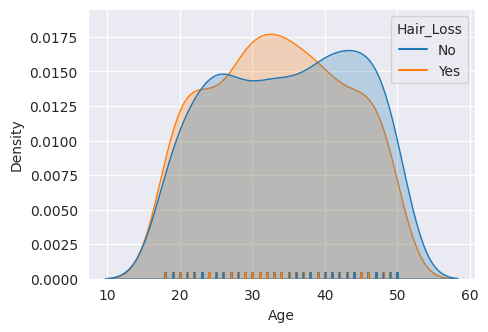

In [35]:
fig,ax = plt.subplots(figsize = (5,3.5))
sns.kdeplot(data_eda, x = 'Age', hue = 'Hair_Loss', fill = True, ax = ax)
sns.rugplot(data_eda, x = 'Age', hue = 'Hair_Loss', ax = ax)
fig.show()

In [36]:
data_eda.groupby('Hair_Loss')['Age'].describe().style.bar(color = 'gold', subset = ['mean', '50%'])

,count,mean,std,min,25%,50%,75%,max
Hair_Loss,,,,,,,,
No,502.000000,34.770916,9.592356,18.000000,26.000000,35.000000,43.000000,50.000000
Yes,497.000000,33.599598,9.128266,18.000000,26.000000,33.000000,41.000000,50.000000


In [37]:
pg.normality(data_eda, dv = 'Age', group = 'Hair_Loss')

,W,pval,normal
Hair_Loss,,,
No,0.950776,7.033666e-12,False
Yes,0.962177,5.326000e-10,False


In [38]:
pg.homoscedasticity(data_eda, dv = 'Age', group = 'Hair_Loss')

,W,pval,equal_var
levene,3.561547,0.059423,True


**Mann-Whitney U Test (= Wilcoxon rank-sum test). It is the non-parametric version of the independent T-test.**

In [39]:
age_no = data_eda.loc[data_eda['Hair_Loss'] == 'No', 'Age']
age_yes = data_eda.loc[data_eda['Hair_Loss'] == 'Yes', 'Age']
pg.mwu(x = age_no, y = age_yes)

,U-val,alternative,p-val,RBC,CLES
MWU,133780.5,two-sided,0.047479,0.072415,0.536207


Genetics vs Hair Loss

In [40]:
fig = px.parallel_categories(data_eda[[categorical_features[0],
                                       categorical_features[10]]])

fig.show()

In [41]:
pd.crosstab(data[categorical_features[0]], data[categorical_features[10]])

Hair_Loss,0,1
Genetics,,
No,250,227
Yes,252,270


chi2 test

In [42]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[0], categorical_features[10])
stats.style.background_gradient(cmap = 'Reds', subset = 'pval')

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,1.543329,1.000000,0.214123,0.039305,0.237166
1,cressie-read,0.666667,1.543424,1.000000,0.214109,0.039306,0.237178
2,log-likelihood,0.000000,1.543748,1.000000,0.214061,0.039310,0.237218
3,freeman-tukey,-0.500000,1.544108,1.000000,0.214007,0.039315,0.237262
4,mod-log-likelihood,-1.000000,1.544568,1.000000,0.213939,0.039321,0.237319
5,neyman,-2.000000,1.545791,1.000000,0.213758,0.039336,0.237470


Hormonal Changes vs HairLoss

In [43]:
fig = px.parallel_categories(data_eda[[categorical_features[1],
                                       categorical_features[10]]])

fig.show()

In [44]:
pd.crosstab(data[categorical_features[1]], data[categorical_features[10]])

Hair_Loss,0,1
Hormonal_Changes,,
No,248,242
Yes,254,255


chi2 test

In [45]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[1], categorical_features[10])
stats.style.background_gradient(cmap = 'Reds', subset = 'pval')

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.025996,1.000000,0.871910,0.005101,0.052983
1,cressie-read,0.666667,0.025996,1.000000,0.871910,0.005101,0.052983
2,log-likelihood,0.000000,0.025996,1.000000,0.871910,0.005101,0.052983
3,freeman-tukey,-0.500000,0.025996,1.000000,0.871909,0.005101,0.052983
4,mod-log-likelihood,-1.000000,0.025996,1.000000,0.871909,0.005101,0.052983
5,neyman,-2.000000,0.025997,1.000000,0.871908,0.005101,0.052983


Medical Conditions vs Hair Loss

In [46]:
fig = px.parallel_categories(data_eda[[categorical_features[2],
                                       categorical_features[10]]])

fig.show()

In [47]:
pd.crosstab(data[categorical_features[2]], data[categorical_features[10]])

Hair_Loss,0,1
Medical_Conditions,,
Alopecia Areata,46,61
Androgenetic Alopecia,43,55
Dermatitis,48,44
Dermatosis,45,43
Eczema,36,33
No Data,63,47
Psoriasis,50,50
Ringworm,36,33
Scalp Infection,41,38


chi2 test

In [48]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[2], categorical_features[10])
stats.style.background_gradient(cmap = 'Spectral', subset = 'pval')

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,9.812281,10.000000,0.457114,0.099107,0.532691
1,cressie-read,0.666667,9.818586,10.000000,0.456551,0.099138,0.533019
2,log-likelihood,0.000000,9.841166,10.000000,0.454537,0.099252,0.534194
3,freeman-tukey,-0.500000,9.866894,10.000000,0.452248,0.099382,0.535530
4,mod-log-likelihood,-1.000000,9.900244,10.000000,0.449288,0.099550,0.537260
5,neyman,-2.000000,9.990203,10.000000,0.441353,0.100001,0.541913


Medications & Treatments vs Hair Loss

In [49]:
fig = px.parallel_categories(data_eda[[categorical_features[3],
                                       categorical_features[10]]])

fig.show()

In [50]:
pd.crosstab(data[categorical_features[3]], data[categorical_features[10]])

Hair_Loss,0,1
Medications_&_Treatments,,
Accutane,52,50
Antibiotics,44,50
Antidepressants,57,53
Antifungal Cream,50,44
Blood Pressure Medication,48,42
Chemotherapy,44,46
Heart Medication,51,53
Immunomodulators,50,40
No Data,1,1


chi2 test

In [51]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[3], categorical_features[10])
stats.style.background_gradient(cmap = 'Reds', subset = 'pval')

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,3.685036,10.000000,0.960439,0.060735,0.198890
1,cressie-read,0.666667,3.686153,10.000000,0.960397,0.060744,0.198946
2,log-likelihood,0.000000,3.690102,10.000000,0.960246,0.060777,0.199144
3,freeman-tukey,-0.500000,3.694569,10.000000,0.960076,0.060813,0.199369
4,mod-log-likelihood,-1.000000,3.700334,10.000000,0.959855,0.060861,0.199658
5,neyman,-2.000000,3.715798,10.000000,0.959258,0.060988,0.200436


Nutritional Deficiencies vs Hair Loss

In [52]:
fig = px.parallel_categories(data_eda[[categorical_features[4],
                                       categorical_features[10]]])

fig.show()

In [53]:
pd.crosstab(data[categorical_features[4]], data[categorical_features[10]])

Hair_Loss,0,1
Nutritional_Deficiencies,,
Biotin Deficiency,53,46
Iron deficiency,38,40
Magnesium deficiency,38,46
No Data,38,42
Omega-3 fatty acids,50,42
Protein deficiency,43,47
Selenium deficiency,40,42
Vitamin A Deficiency,48,51
Vitamin D Deficiency,52,52


chi2 test

In [54]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[4], categorical_features[10])
stats.style.background_gradient(cmap = 'Reds', subset = 'pval')


,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,3.420011,10.000000,0.969745,0.058510,0.185719
1,cressie-read,0.666667,3.420773,10.000000,0.969720,0.058517,0.185757
2,log-likelihood,0.000000,3.423414,10.000000,0.969635,0.058539,0.185887
3,freeman-tukey,-0.500000,3.426376,10.000000,0.969539,0.058565,0.186032
4,mod-log-likelihood,-1.000000,3.430183,10.000000,0.969416,0.058597,0.186220
5,neyman,-2.000000,3.440349,10.000000,0.969085,0.058684,0.186720


Stress vs Hair Loss

In [55]:
fig = px.parallel_categories(data_eda[[categorical_features[5],
                                       categorical_features[10]]])

fig.show()

In [56]:
pd.crosstab(data[categorical_features[5]], data[categorical_features[10]])

Hair_Loss,0,1
Stress,,
High,165,156
Low,168,159
Moderate,169,182


chi2 test

In [57]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[5], categorical_features[10])
stats.style.background_gradient(cmap = 'Reds', subset = 'pval')

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.956523,2.000000,0.619860,0.030943,0.128847
1,cressie-read,0.666667,0.956550,2.000000,0.619852,0.030944,0.128849
2,log-likelihood,0.000000,0.956674,2.000000,0.619813,0.030946,0.128860
3,freeman-tukey,-0.500000,0.956828,2.000000,0.619765,0.030948,0.128874
4,mod-log-likelihood,-1.000000,0.957036,2.000000,0.619701,0.030951,0.128892
5,neyman,-2.000000,0.957611,2.000000,0.619523,0.030961,0.128943


Poor Hair Care Habits vs Hair Loss

In [58]:
fig = px.parallel_categories(data_eda[[categorical_features[6],
                                       categorical_features[10]]])

fig.show()

In [59]:
pd.crosstab(data[categorical_features[6]], data[categorical_features[10]])

Hair_Loss,0,1
Poor_Hair_Care_Habits,,
No,245,262
Yes,257,235


chi2 test

In [60]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[6], categorical_features[10])
stats.style.background_gradient(cmap = 'Reds', subset = 'pval')

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,1.376282,1.000000,0.240735,0.037117,0.216560
1,cressie-read,0.666667,1.376354,1.000000,0.240723,0.037118,0.216569
2,log-likelihood,0.000000,1.376604,1.000000,0.240681,0.037121,0.216600
3,freeman-tukey,-0.500000,1.376883,1.000000,0.240633,0.037125,0.216635
4,mod-log-likelihood,-1.000000,1.377242,1.000000,0.240571,0.037130,0.216679
5,neyman,-2.000000,1.378198,1.000000,0.240408,0.037143,0.216797


Environmental Factors vs Hair Loss

In [61]:
fig = px.parallel_categories(data_eda[[categorical_features[7],
                                       categorical_features[10]]])

fig.show()

In [62]:
pd.crosstab(data[categorical_features[7]], data[categorical_features[10]])

Hair_Loss,0,1
Environmental_Factors,,
No,242,249
Yes,260,248


In [63]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[7], categorical_features[10])
stats.style.background_gradient(cmap = 'Reds', subset = 'pval')

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.286491,1.000000,0.592478,0.016935,0.083414
1,cressie-read,0.666667,0.286494,1.000000,0.592476,0.016935,0.083414
2,log-likelihood,0.000000,0.286504,1.000000,0.592470,0.016935,0.083415
3,freeman-tukey,-0.500000,0.286516,1.000000,0.592462,0.016935,0.083417
4,mod-log-likelihood,-1.000000,0.286531,1.000000,0.592452,0.016936,0.083419
5,neyman,-2.000000,0.286572,1.000000,0.592426,0.016937,0.083423


Smoking vs Hair Loss

In [64]:
fig = px.parallel_categories(data_eda[[categorical_features[8],
                                       categorical_features[10]]])

fig.show()

In [65]:
pd.crosstab(data[categorical_features[8]], data[categorical_features[10]])

Hair_Loss,0,1
Smoking,,
No,227,253
Yes,275,244


In [66]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[8], categorical_features[10])
stats.style.background_gradient(cmap = 'Reds', subset = 'pval')

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,3.011238,1.000000,0.082689,0.054902,0.411227
1,cressie-read,0.666667,3.011562,1.000000,0.082673,0.054905,0.411263
2,log-likelihood,0.000000,3.012719,1.000000,0.082614,0.054916,0.411393
3,freeman-tukey,-0.500000,3.014031,1.000000,0.082547,0.054928,0.411540
4,mod-log-likelihood,-1.000000,3.015727,1.000000,0.082460,0.054943,0.411729
5,neyman,-2.000000,3.020268,1.000000,0.082230,0.054984,0.412238


Weights Loss vs Hair Loss

In [67]:
fig = px.parallel_categories(data_eda[[categorical_features[9],
                                       categorical_features[10]]])

fig.show()

In [68]:
pd.crosstab(data[categorical_features[9]], data[categorical_features[10]])

Hair_Loss,0,1
Weight_Loss,,
No,276,251
Yes,226,246


In [69]:
_,_, stats = pg.chi2_independence(data_eda, categorical_features[9], categorical_features[10])
stats.style.background_gradient(cmap = 'Reds', subset = 'pval')

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,1.832831,1.000000,0.175794,0.042833,0.272670
1,cressie-read,0.666667,1.832947,1.000000,0.175780,0.042834,0.272684
2,log-likelihood,0.000000,1.833369,1.000000,0.175730,0.042839,0.272736
3,freeman-tukey,-0.500000,1.833852,1.000000,0.175673,0.042845,0.272795
4,mod-log-likelihood,-1.000000,1.834477,1.000000,0.175600,0.042852,0.272871
5,neyman,-2.000000,1.836153,1.000000,0.175402,0.042872,0.273075


**Predictive Power Score(PPS)**

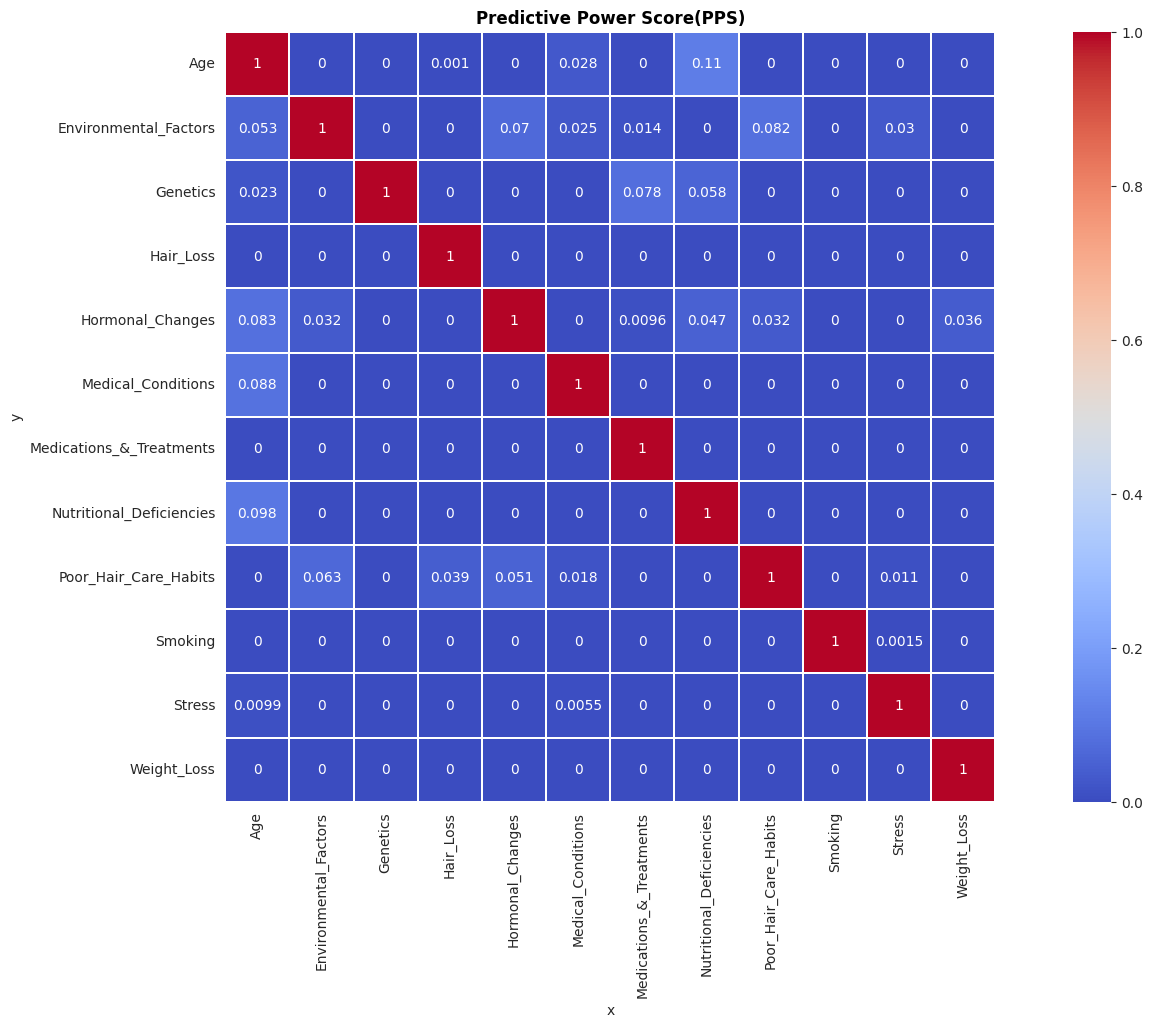

In [70]:
corr_matrix_pps = pps.matrix(data)[['x','y','ppscore']].pivot_table(index = 'y',
                                                                    columns = 'x',
                                                                    values = 'ppscore')

plt.figure(figsize = (20,10))
sns.heatmap(corr_matrix_pps,
            cmap ='coolwarm',
            annot = True,
            linewidths = 1.1,
            square = True)
plt.title("Predictive Power Score(PPS)", fontsize = 12, fontweight = 'bold', color = 'black')
plt.show()

**Multivariate Analysis**

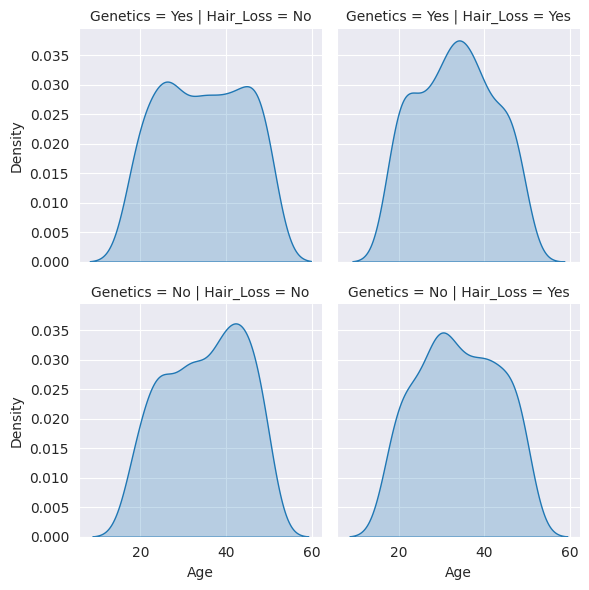

In [71]:
g = sns.FacetGrid(data_eda, col="Hair_Loss",  row="Genetics")
g.map_dataframe(sns.kdeplot, x="Age", fill = True)

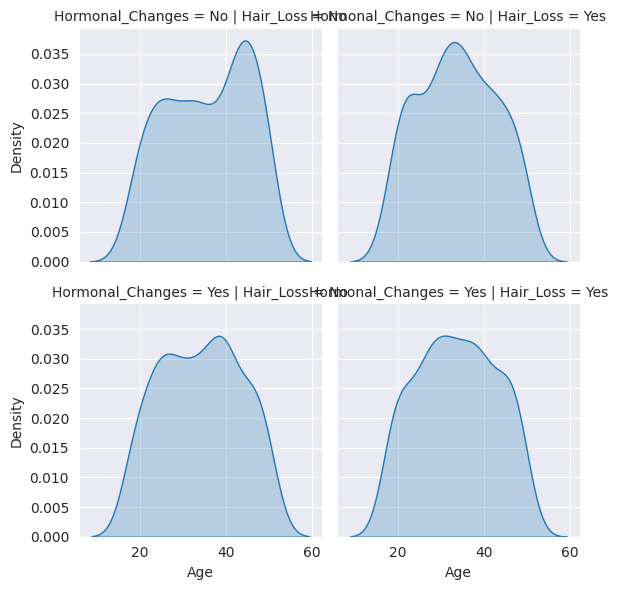

In [72]:
g = sns.FacetGrid(data_eda, col="Hair_Loss",  row = categorical_features[1])
g.map_dataframe(sns.kdeplot, x="Age", fill = True)

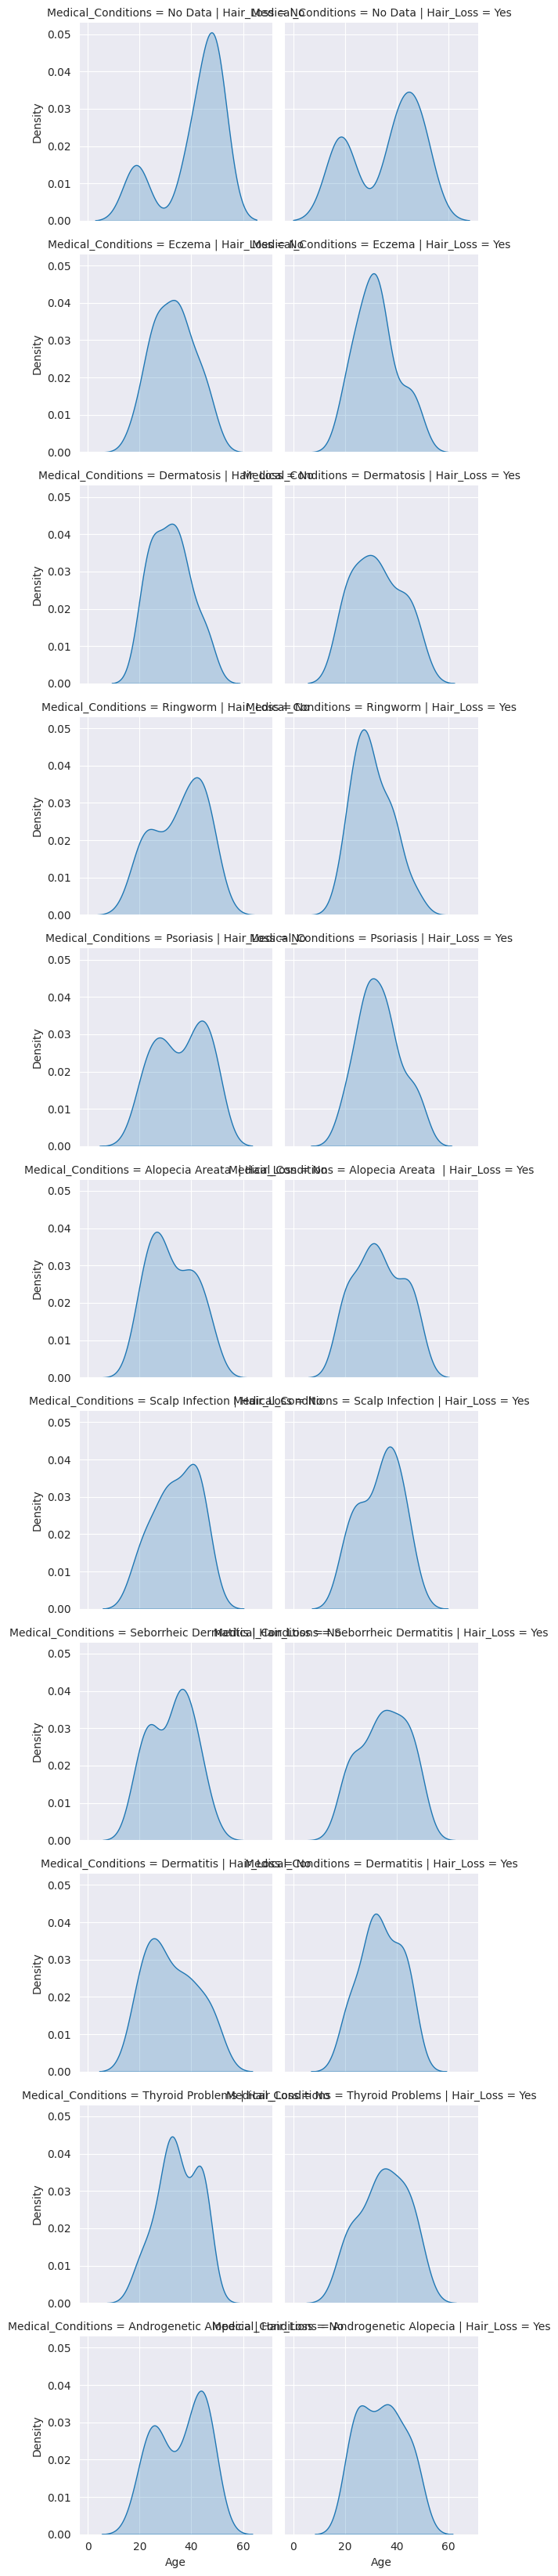

In [73]:
g = sns.FacetGrid(data_eda, col="Hair_Loss",  row = categorical_features[2])
g.map_dataframe(sns.kdeplot, x="Age", fill = True)

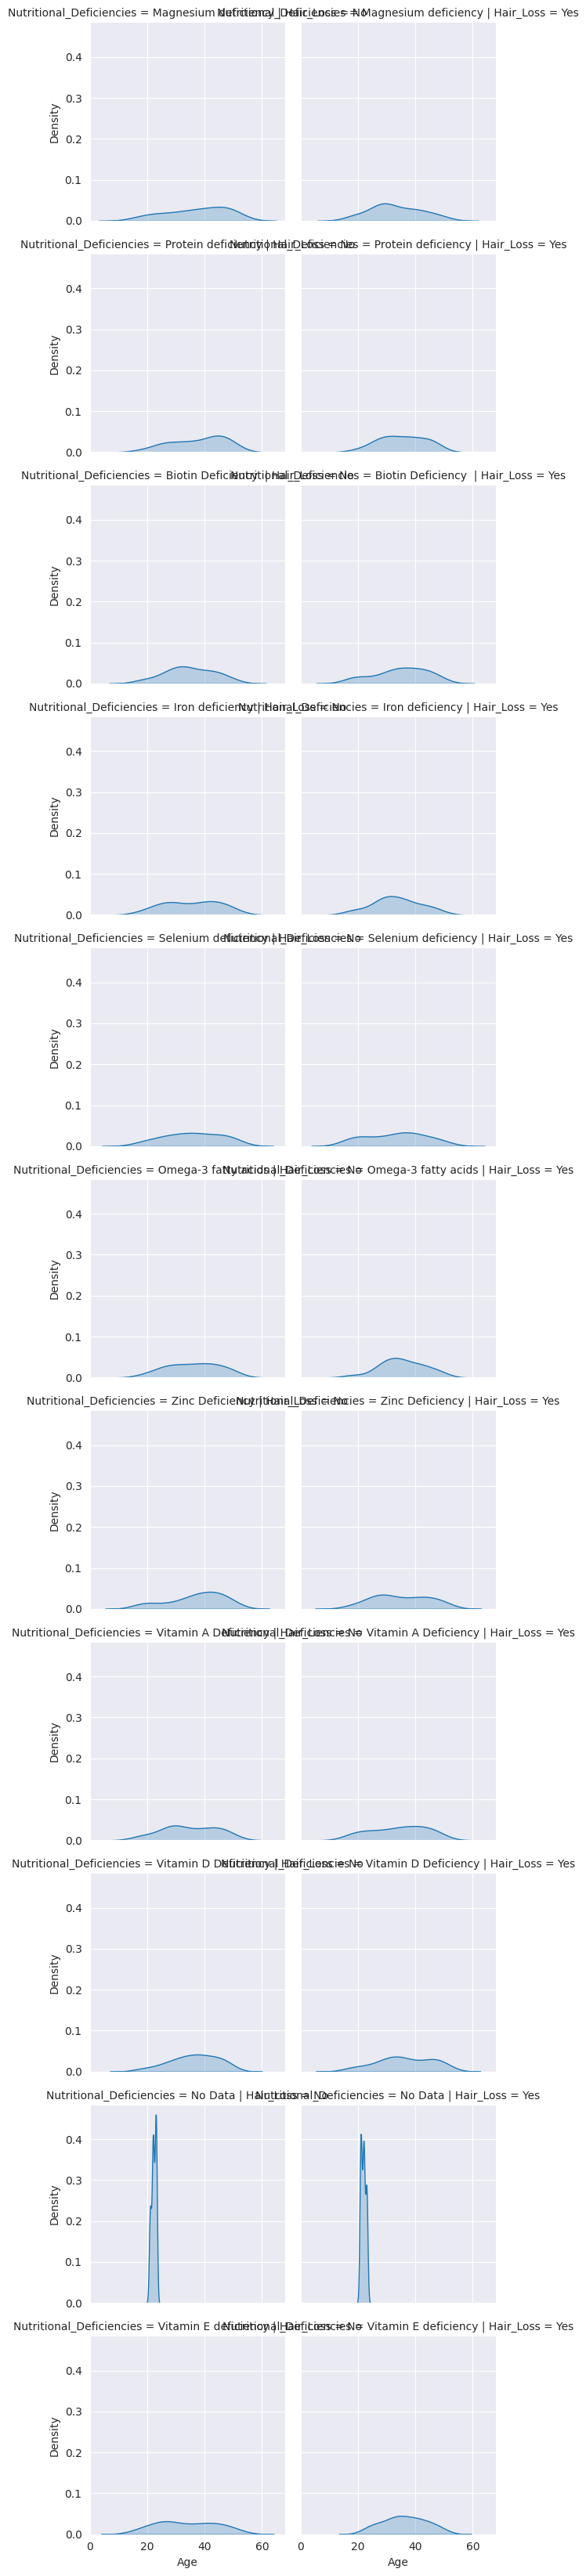

In [74]:
g = sns.FacetGrid(data_eda, col="Hair_Loss",  row = categorical_features[4])
g.map_dataframe(sns.kdeplot, x="Age", fill = True)

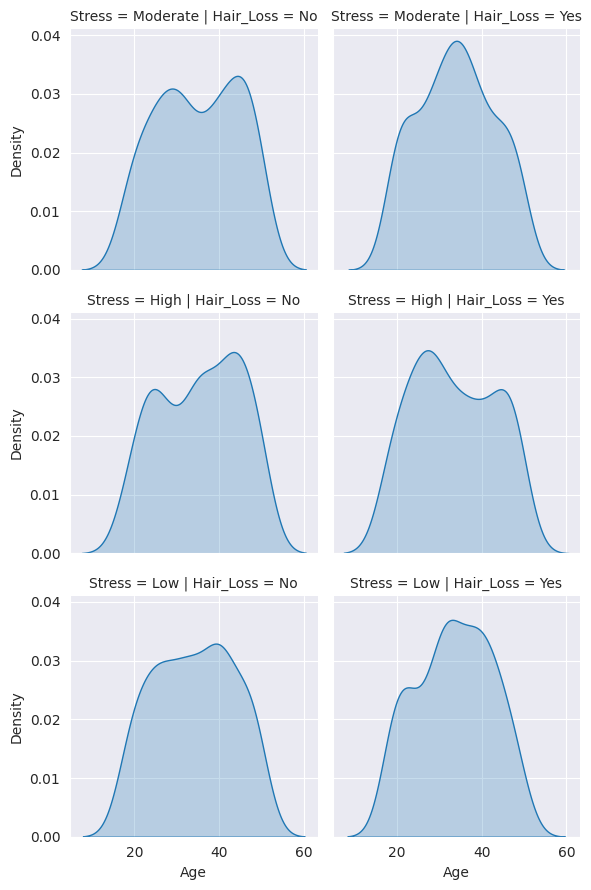

In [75]:
g = sns.FacetGrid(data_eda, col="Hair_Loss",  row = categorical_features[5])
g.map_dataframe(sns.kdeplot, x="Age", fill = True)

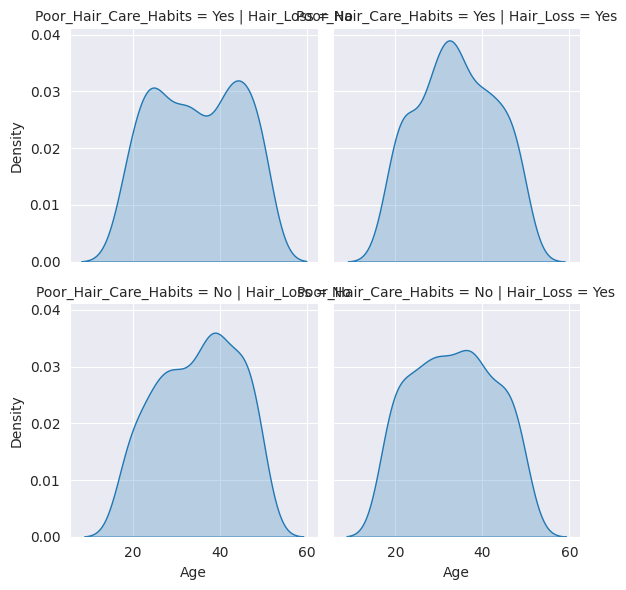

In [76]:
g = sns.FacetGrid(data_eda, col="Hair_Loss",  row = categorical_features[6])
g.map_dataframe(sns.kdeplot, x="Age", fill = True)

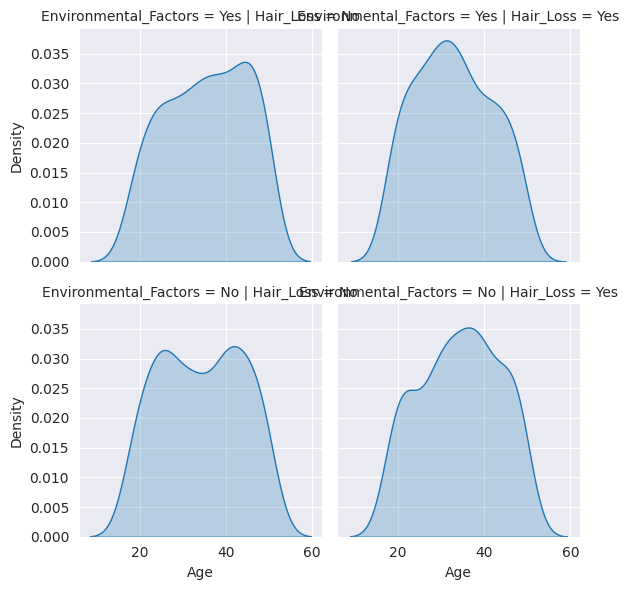

In [77]:
g = sns.FacetGrid(data_eda, col="Hair_Loss",  row = categorical_features[7])
g.map_dataframe(sns.kdeplot, x="Age", fill = True)

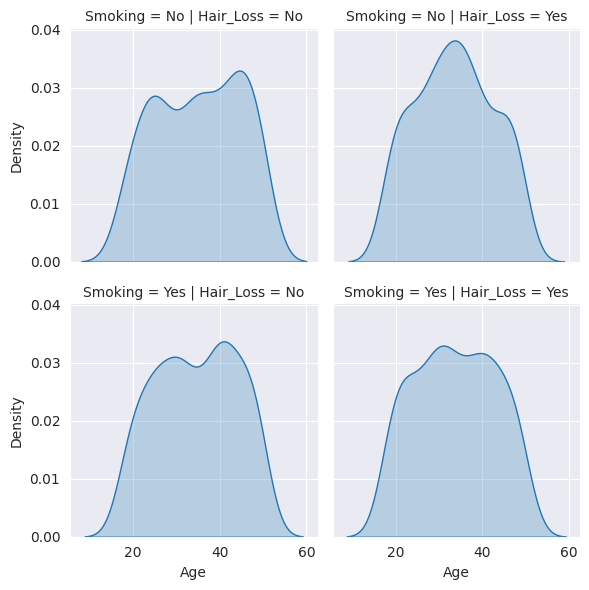

In [78]:
g = sns.FacetGrid(data_eda, col="Hair_Loss",  row = categorical_features[8])
g.map_dataframe(sns.kdeplot, x="Age", fill = True)

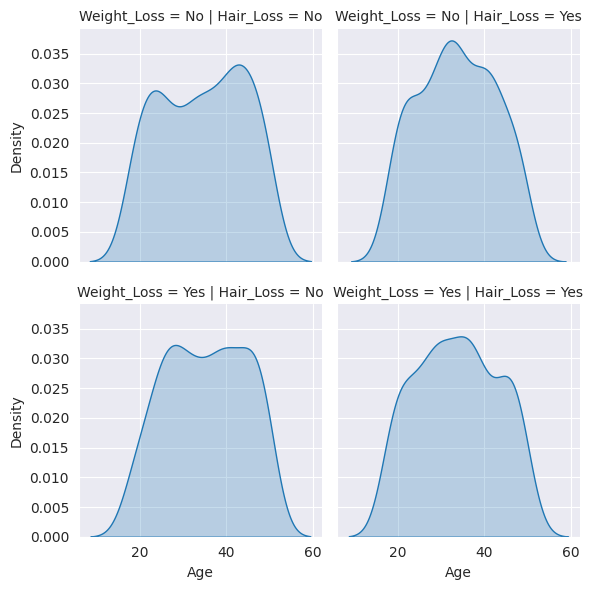

In [79]:
g = sns.FacetGrid(data_eda, col="Hair_Loss",  row = categorical_features[9])
g.map_dataframe(sns.kdeplot, x="Age", fill = True)

**Preprocessing**

In [80]:
X = data.drop(columns = ['Hair_Loss'])
y = data['Hair_Loss']

In [81]:
SEED = 1234

X_train, X_test, y_train, y_test = tts(X,
                                       y,
                                       test_size = 0.3,
                                       random_state = SEED,
                                       stratify = y)

In [82]:
Counter(y_train)

Counter({0: 351, 1: 348})

In [83]:
Counter(y_test)

Counter({0: 151, 1: 149})

In [84]:
numerical_predictor = X_train.select_dtypes(include = ['int', 'float']).columns.to_list()
categorical_predictors = X_train.select_dtypes(include = ['object', 'category']).columns.to_list()

In [85]:
preprocessor = ColumnTransformer([('te', TargetEncoder(min_samples_leaf = 1), categorical_predictors),
                                   ('kbins', KBinsDiscretizer(n_bins = 10,encode = 'onehot-dense', random_state = SEED), numerical_predictor)],
                                 remainder = 'passthrough',
                                 verbose_feature_names_out = False).set_output(transform = 'pandas')

X_train_prep = preprocessor.fit_transform(X_train, y_train)
X_test_prep = preprocessor.transform(X_test)

**Models**

In [86]:
# We create a function to calculate the f2 score metric in hyperparameter optimization.
def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2)
    return f2_score

def f2_scorer():
    return make_scorer(f2_func)

**Logistic Regression**

In [87]:
lr = LogisticRegression(class_weight = 'balanced', random_state = SEED)
lr.fit(X_train_prep, y_train)

y_pred_train = lr.predict(X_train_prep)
y_pred_test = lr.predict(X_test_prep)

print(f'F2 Train: {fbeta_score(y_train, y_pred_train, beta = 2):.4f}')
print(f'F2 Test: {fbeta_score(y_test, y_pred_test, beta = 2):.4f}')

F2 Train: 0.6507
F2 Test: 0.6124


In [88]:
bg = BaggingClassifier(estimator = LogisticRegression(class_weight = 'balanced',
                                                      random_state = SEED,
                                                      n_jobs = -1, C = 2.0),
                       n_estimators = 200,
                       max_samples = 0.2,
                       n_jobs = -1,
                       random_state = SEED)

bg.fit(X_train_prep, y_train)
y_pred_train = bg.predict(X_train_prep)
y_pred_test = bg.predict(X_test_prep)

print(f'F2 Train: {fbeta_score(y_train, y_pred_train, beta = 2):.4f}')
print(f'F2 Test: {fbeta_score(y_test, y_pred_test, beta = 2):.4f}')

F2 Train: 0.6942
F2 Test: 0.7013


**SVC**

In [89]:
svc = SVC(probability = True, random_state = SEED)
svc.fit(X_train_prep, y_train)

y_pred_train = svc.predict(X_train_prep)
y_pred_test = svc.predict(X_test_prep)

print(f'F2 Train: {fbeta_score(y_train, y_pred_train, beta = 2):.4f}')
print(f'F2 Test: {fbeta_score(y_test, y_pred_test, beta = 2):.4f}')

F2 Train: 0.6710
F2 Test: 0.6564


**KNN**

In [90]:
knn = KNeighborsClassifier()
knn.fit(X_train_prep, y_train)

y_pred_train = knn.predict(X_train_prep)
y_pred_test = knn.predict(X_test_prep)

print(f'F2 Train: {fbeta_score(y_train, y_pred_train, beta = 2):.4f}')
print(f'F2 Test: {fbeta_score(y_test, y_pred_test, beta = 2):.4f}')

F2 Train: 0.6846
F2 Test: 0.4286


In [91]:
# We tune the KNN model.
def objective(trial):
    params = {'n_neighbors':trial.suggest_int('n_neighbors', 5, 100),
              'weights':trial.suggest_categorical('weights', ['uniform','distance']),
              'metric':trial.suggest_categorical('metric', ['minkowski','cosine','euclidean','manhattan','l2'])
              }

    estimator = KNeighborsClassifier(**params,
                                     n_jobs = -1)

    score = cross_val_score(estimator, X = X_train_prep, y = y_train,
                            scoring = f2_scorer(),
                            cv = StratifiedKFold(n_splits = 10),
                            n_jobs = -1)

    f2 = score.mean()

    return f2

In [92]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200, show_progress_bar = True)

[I 2025-02-23 04:38:49,286] A new study created in memory with name: no-name-c66ee416-c6b4-4a7d-944d-4a33274219c9


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-02-23 04:38:49,482] Trial 0 finished with value: 0.47246326571649905 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'l2'}. Best is trial 0 with value: 0.47246326571649905.
[I 2025-02-23 04:38:49,775] Trial 1 finished with value: 0.5115375352642451 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 1 with value: 0.5115375352642451.
[I 2025-02-23 04:38:50,116] Trial 2 finished with value: 0.5414371499567734 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'metric': 'cosine'}. Best is trial 2 with value: 0.5414371499567734.
[I 2025-02-23 04:38:50,250] Trial 3 finished with value: 0.5932355107619761 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'l2'}. Best is trial 3 with value: 0.5932355107619761.
[I 2025-02-23 04:38:50,373] Trial 4 finished with value: 0.5701519388643378 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 3 with value: 0.5932

In [93]:
study.best_params

{'n_neighbors': 99, 'weights': 'uniform', 'metric': 'cosine'}

In [94]:
knn = KNeighborsClassifier(n_neighbors = 99,
                          weights = 'uniform',
                          metric = 'cosine',
                          n_jobs = -1)

knn.fit(X_train_prep, y_train)

y_pred_train = knn.predict(X_train_prep)
y_pred_test = knn.predict(X_test_prep)

print(f'F2 Train: {fbeta_score(y_train, y_pred_train, beta = 2):.4f}')
print(f'F2 Test: {fbeta_score(y_test, y_pred_test, beta = 2):.4f}')

F2 Train: 0.7584
F2 Test: 0.7344


**Stacking Classifier**

In [95]:
e1 = BaggingClassifier(estimator = LogisticRegression(class_weight = 'balanced',
                                                      random_state = SEED,
                                                      n_jobs = -1),
                       n_estimators = 200,
                       max_samples = 0.2,
                       n_jobs = -1,
                       random_state = SEED)

e2 = SVC(probability = True, random_state = SEED)
e3 = KNeighborsClassifier(n_neighbors = 99,
                          weights = 'uniform',
                          metric = 'cosine',
                          n_jobs = -1)

ESTIMATORS = [('lr',e1), ('knn', e3)]

stacking = StackingClassifier(estimators = ESTIMATORS, final_estimator = e2,
                              cv = StratifiedKFold(n_splits = 5))
stacking.fit(X_train_prep, y_train)


y_pred_train = stacking.predict(X_train_prep)
y_pred_test = stacking.predict(X_test_prep)

print(f'F2 Train: {fbeta_score(y_train, y_pred_train, beta = 2):.4f}')
print(f'F2 Test: {fbeta_score(y_test, y_pred_test, beta = 2):.4f}')

F2 Train: 0.7742
F2 Test: 0.7706


** Metrics**

Classification report

In [96]:
print("##" * 40)
print(" " * 25, "Classification Report Train")
print("##" * 40)
print(classification_report(y_train, y_pred_train, target_names = ['No','Yes']))
print("")

print("##" * 40)
print(" " * 25, "Classification Report Test")
print("##" * 40)
print(classification_report(y_test, y_pred_test, target_names = ['No','Yes']))

################################################################################
                          Classification Report Train
################################################################################
              precision    recall  f1-score   support

          No       0.57      0.15      0.23       351
         Yes       0.51      0.89      0.65       348

    accuracy                           0.52       699
   macro avg       0.54      0.52      0.44       699
weighted avg       0.54      0.52      0.44       699


################################################################################
                          Classification Report Test
################################################################################
              precision    recall  f1-score   support

          No       0.52      0.11      0.18       151
         Yes       0.50      0.89      0.64       149

    accuracy                           0.50       300
   macro avg       0.51

Confusion Matrix

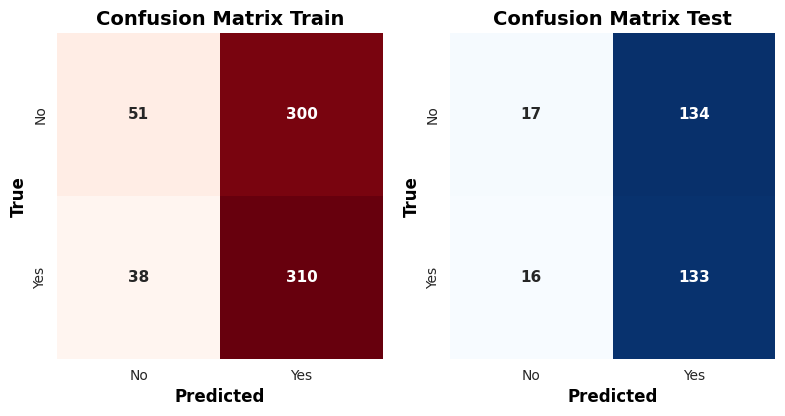

In [97]:
cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
axs = axs.flat

sns.heatmap(cf_mx_train, cmap = 'Reds', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', xticklabels = ['No', 'Yes'], yticklabels = ['No', 'Yes'], cbar = False, square = True, ax = axs[0])
sns.heatmap(cf_mx_test, cmap = 'Blues', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', xticklabels = ['No', 'Yes'], yticklabels = ['No', 'Yes'], cbar = False, square = True, ax = axs[1])
axs[0].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_title('Confusion Matrix Train', fontsize = 14, fontweight = "bold", color = "black")
axs[1].set_title('Confusion Matrix Test', fontsize = 14, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()